<a href="https://colab.research.google.com/github/CompClimate/extremeWaterLeverForecastingHwy37/blob/main/Petaluma_River_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import numpy as np
from datetime import datetime
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, LayerNormalization
from tensorflow.keras.models import Model
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

#Single Transformer

In [ ]:
pip install shap

In [ ]:
path = '/content/drive/MyDrive/hwy37/Input_trainingset.csv'
df = pd.read_csv(path)

tide_path = '/content/drive/MyDrive/hwy37/export_tide.csv'
tide_df = pd.read_csv(tide_path)

path_pstage = '/content/drive/MyDrive/hwy37/petaluma_wl_new.csv'
pet_stage = pd.read_csv(path_pstage)
p_stage = np.asarray(pet_stage)

path_p1hr = '/content/drive/MyDrive/hwy37/petaluma_wl_1hr.csv'
pet_stage_1hr = pd.read_csv(path_p1hr)
p_1hr = np.asarray(pet_stage_1hr)

dfX = pd.read_csv('/content/drive/MyDrive/hwy37/Input_trainingset.csv',parse_dates=[0], index_col=0)
dfY = pd.read_csv('/content/drive/MyDrive/hwy37/petaluma_wl_1hr.csv',parse_dates=[0], index_col=0)

X_df = pd.DataFrame(index = dfX.index)
# run a rolling mean with 12 window to get rid of the "fuzz"
X_df['Baro_pressure']=dfX.AtmPres.rolling(12, min_periods=1, center=True).mean()
X_df['Ocean_wind']=dfX.ocean_onshorewind.rolling(12, min_periods=1, center=True).mean()
X_df['Local_wind']=dfX.Gnoss_onshorewind.rolling(12, min_periods=1, center=True).mean()
# There is a delay between when a flow peak is observed at the flow gage and when its effect on the
# downstream water level gauge.
# The delay between Napa River flow and Novato Mouth is -3 hour
# The delay between Napa River flow and Rowland Bridge is -1 hour
# The delay between Napa River flow and Petaluma is -3 hour

lag = 0 # for now lets keep it at 0 because it create this gap between training and forecast
X_df['napa_flow_cfs'] = dfX.napa_flow_cfs.shift(lag)

# 2. Assure y and X_df are the same size and do not have NAN
# I concat them and delete any row that have NaN at the end. That assure
# we have a solid block of data with out the frayed ends or NaN at the beginning
X_df = pd.concat([X_df, dfY.residual_m], axis=1).dropna(how='any')

#corr_mat = X_df.corr()

y = X_df.residual_m
Y_df = dfY.truncate(before = X_df.index[0], after=X_df.index[-1], axis=0) # truncated version of the original WL DF

X_df = X_df.drop(columns=['residual_m'])

#X_df = X_df.reset_index()
#X_df = X_df.rename(columns={'index': 'date'})

#lookback = 12
#for i in range(1, lookback + 1):
#    X_df[f'Baro_pressure_lagged_{i}'] = X_df['Baro_pressure'].shift(i)
#    X_df[f'Ocean_wind_lagged_{i}'] = X_df['Ocean_wind'].shift(i)
#    X_df[f'Local_wind_lagged_{i}'] = X_df['Local_wind'].shift(i)
#    X_df[f'napa_flow_cfs_lagged_{i}'] = X_df['napa_flow_cfs'].shift(i)
#    X_df[f'residual_m_lagged_{i}'] = Y_df['residual_m'].shift(i)
#X_df.dropna(inplace=True)

#X_df['Baro_pressure_lagged'] = X_df['Baro_pressure'].shift(lookback)
#X_df['Ocean_wind_lagged'] = X_df['Ocean_wind'].shift(lookback)
#X_df['Local_wind_lagged'] = X_df['Local_wind'].shift(lookback)
#X_df['napa_flow_cfs_lagged'] = X_df['napa_flow_cfs'].shift(lookback)
#X_df['residual_m_lagged'] = Y_df['residual_m'].shift(lookback)

X_train, X_val, y_train, y_val = train_test_split(X_df[0:20000], y[0:20000], shuffle=False, test_size = 0.1)

X_train = np.asarray(X_train)
X_val = np.asarray(X_val)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer

#positional encoding example from keras
def positional_encoding(position, d_model):
     angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                           np.arange(d_model)[np.newaxis, :],
                           d_model)

     # apply sin to even indices in the array; 2i
     angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

     # apply cos to odd indices in the array; 2i+1
     angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

     pos_encoding = angle_rads[np.newaxis, ...]

     return tf.cast(pos_encoding, dtype=tf.float32)

def get_angles(pos, i, d_model):
     angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
     return pos * angle_rates

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head self-attention
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs  # Residual connection

    # Feed-forward network
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res  # Residual connection

def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, vocab_size, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    embedding_layer = layers.Embedding(vocab_size, head_size)(inputs)

    seq_len = input_shape[0]
    pos_encoding = positional_encoding(seq_len, head_size)

    pos_encoding = tf.reshape(pos_encoding, (1, input_shape[0], head_size))
    x = embedding_layer + pos_encoding

    x = layers.Lambda(lambda tensor: tf.squeeze(tensor, axis=1))(x)

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

def sse_loss(y_true, y_pred):
    return tf.reduce_sum(tf.square(y_true - y_pred))

input_shape = (1, 4) #4 for no lagged features

model = build_model(
    input_shape,
    head_size=64, #256
    num_heads=8,
    ff_dim=16, #4
    num_transformer_blocks=1,
    mlp_units=[128], #128
    mlp_dropout=0.1,
    dropout=0.1,
    vocab_size=4096  # Pass the vocabulary size
)

model.compile(
    loss='mse',
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mse"]  # Mean Absolute Error
)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30)

Epoch 1/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.1841 - mse: 0.1841 - val_loss: 0.0274 - val_mse: 0.0274
Epoch 2/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 3/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0214 - val_mse: 0.0214
Epoch 4/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0203 - val_mse: 0.0203
Epoch 5/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0189 - val_mse: 0.0189
Epoch 6/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0174 - val_mse: 0.0174
Epoch 7/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0164 - val_mse: 0.0164
Epoch 8/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0193 - val_mse: 0.0193
Epoch 9/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


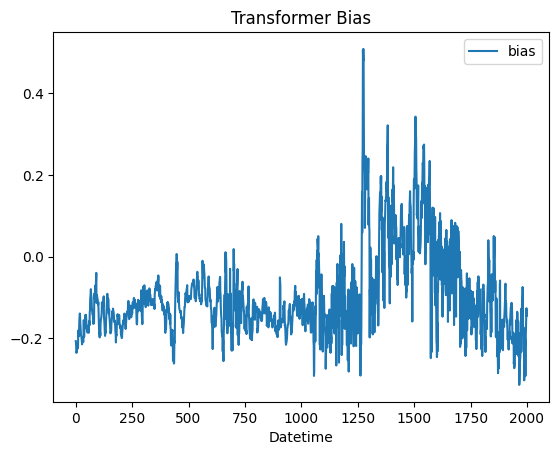

In [ ]:
y_pred = model.predict(X_val)
plt.plot(y_val - y_pred.reshape(y_pred.shape[0]), label='bias')
plt.title('Transformer Bias')
plt.xlabel('Datetime')
plt.legend()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation MSE: 0.02040842291683193
Validation MAE: 0.12863284717554935


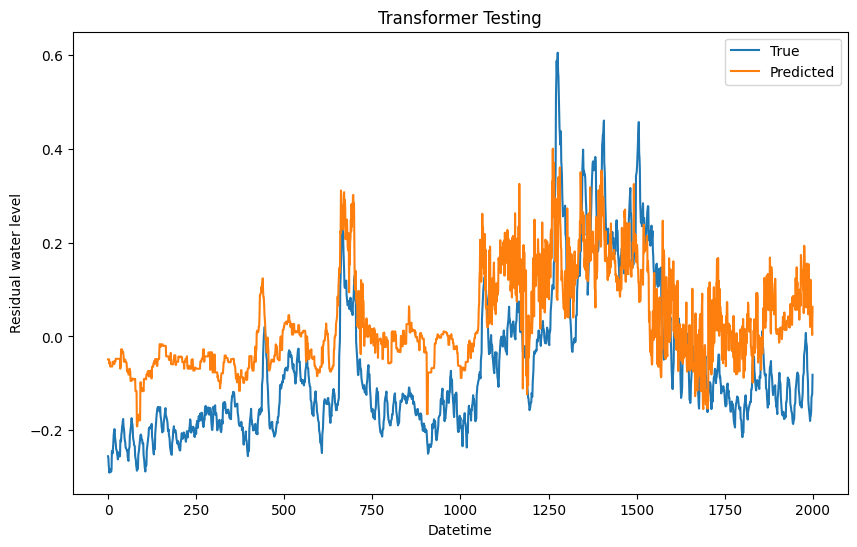

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
print(f"Validation MSE: {mse}")
print(f"Validation MAE: {mae}")

plt.figure(figsize=(10, 6))
plt.plot(y_val, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Transformer Testing')
plt.xlabel('Datetime')
plt.ylabel('Residual water level')
plt.show()

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation MSE: 0.005299805111287787
Validation MAE: 0.05107690452886321


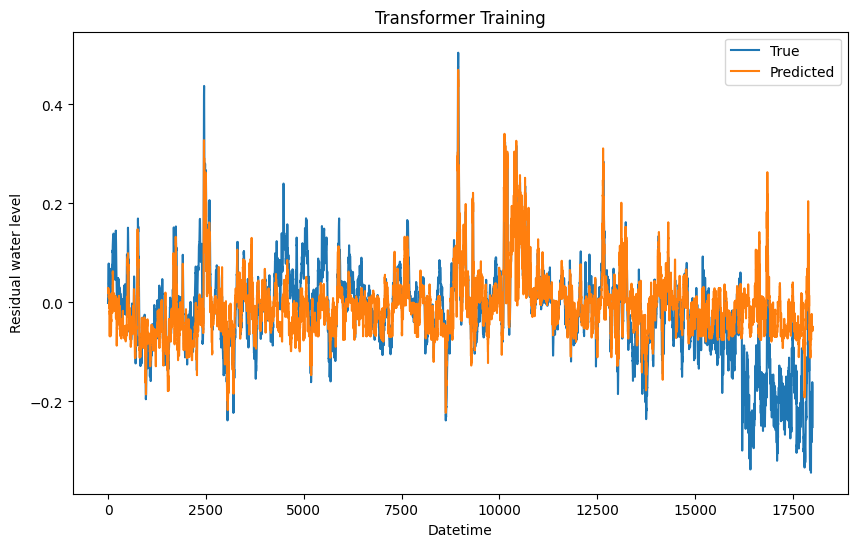

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
print(f"Validation MSE: {mse}")
print(f"Validation MAE: {mae}")

plt.figure(figsize=(10, 6))
plt.plot(y_train, label='True')
plt.plot(y_pred, label='Predicted')
plt.title('Transformer Training')
plt.xlabel('Datetime')
plt.ylabel('Residual water level')
plt.legend()
plt.show()

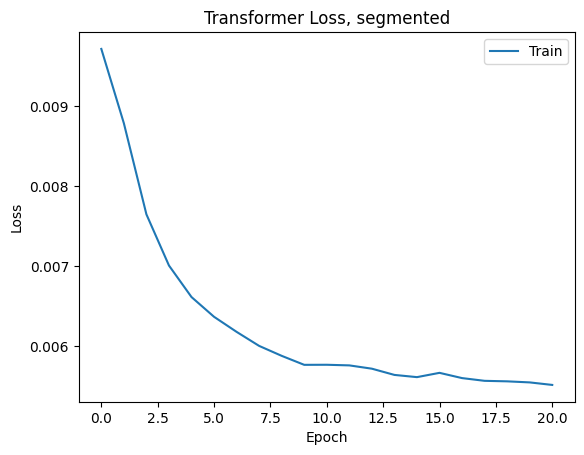

In [ ]:
plt.plot(history.history['loss'][1:22])  # Plot training loss
plt.title('Transformer Loss, segmented')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

#Ensemble Transformer

In [ ]:
pip install shap

In [ ]:
path = '/content/drive/MyDrive/hwy37/Input_trainingset.csv'
df = pd.read_csv(path)

tide_path = '/content/drive/MyDrive/hwy37/export_tide.csv'
tide_df = pd.read_csv(tide_path)

path_pstage = '/content/drive/MyDrive/hwy37/petaluma_wl_new.csv'
pet_stage = pd.read_csv(path_pstage)
p_stage = np.asarray(pet_stage)

path_p1hr = '/content/drive/MyDrive/hwy37/petaluma_wl_1hr.csv'
pet_stage_1hr = pd.read_csv(path_p1hr)
p_1hr = np.asarray(pet_stage_1hr)

dfX = pd.read_csv('/content/drive/MyDrive/hwy37/Input_trainingset.csv',parse_dates=[0], index_col=0)
dfY = pd.read_csv('/content/drive/MyDrive/hwy37/petaluma_wl_1hr.csv',parse_dates=[0], index_col=0)

X_df = pd.DataFrame(index = dfX.index)
# run a rolling mean with 12 window to get rid of the "fuzz"
X_df['Baro_pressure']=dfX.AtmPres.rolling(12, min_periods=1, center=True).mean()
X_df['Ocean_wind']=dfX.ocean_onshorewind.rolling(12, min_periods=1, center=True).mean()
X_df['Local_wind']=dfX.Gnoss_onshorewind.rolling(12, min_periods=1, center=True).mean()
# There is a delay between when a flow peak is observed at the flow gage and when its effect on the
# downstream water level gauge.
# The delay between Napa River flow and Novato Mouth is -3 hour
# The delay between Napa River flow and Rowland Bridge is -1 hour
# The delay between Napa River flow and Petaluma is -3 hour

lag = 0 # for now lets keep it at 0 because it create this gap between training and forecast
X_df['napa_flow_cfs'] = dfX.napa_flow_cfs.shift(lag)

# 2. Assure y and X_df are the same size and do not have NAN
# I concat them and delete any row that have NaN at the end. That assure
# we have a solid block of data with out the frayed ends or NaN at the beginning
X_df = pd.concat([X_df, dfY.residual_m], axis=1).dropna(how='any')

#corr_mat = X_df.corr()

y = X_df.residual_m
Y_df = dfY.truncate(before = X_df.index[0], after=X_df.index[-1], axis=0) # truncated version of the original WL DF

X_df = X_df.drop(columns=['residual_m'])

#X_df = X_df.reset_index()
#X_df = X_df.rename(columns={'index': 'date'})

#lookback = 12
#for i in range(1, lookback + 1):
#    X_df[f'Baro_pressure_lagged_{i}'] = X_df['Baro_pressure'].shift(i)
#    X_df[f'Ocean_wind_lagged_{i}'] = X_df['Ocean_wind'].shift(i)
#    X_df[f'Local_wind_lagged_{i}'] = X_df['Local_wind'].shift(i)
#    X_df[f'napa_flow_cfs_lagged_{i}'] = X_df['napa_flow_cfs'].shift(i)
#    X_df[f'residual_m_lagged_{i}'] = Y_df['residual_m'].shift(i)
#X_df.dropna(inplace=True)

#X_df['Baro_pressure_lagged'] = X_df['Baro_pressure'].shift(lookback)
#X_df['Ocean_wind_lagged'] = X_df['Ocean_wind'].shift(lookback)
#X_df['Local_wind_lagged'] = X_df['Local_wind'].shift(lookback)
#X_df['napa_flow_cfs_lagged'] = X_df['napa_flow_cfs'].shift(lookback)
#X_df['residual_m_lagged'] = Y_df['residual_m'].shift(lookback)

X_train, X_val, y_train, y_val = train_test_split(X_df[0:20000], y[0:20000], shuffle=False, test_size = 0.1)

X_train = np.asarray(X_train)
X_val = np.asarray(X_val)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

In [ ]:
X_train.shape

(18000, 1, 64)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
import shap

def positional_encoding(position, d_model):
     angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                           np.arange(d_model)[np.newaxis, :],
                           d_model)

     # apply sin to even indices in the array; 2i
     angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

     # apply cos to odd indices in the array; 2i+1
     angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

     pos_encoding = angle_rads[np.newaxis, ...]

     return tf.cast(pos_encoding, dtype=tf.float32)

def get_angles(pos, i, d_model):
     angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
     return pos * angle_rates

def model_wrapper(x):
  """Wraps the model prediction to handle input shape expected by shap."""
  x_reshaped = x.reshape(x.shape[0], 1, x.shape[1])  # Reshape to (samples, 1, features)
  return model.predict(x_reshaped)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head self-attention
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs  # Residual connection

    # Feed-forward network
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res  # Residual connection

def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, vocab_size, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    embedding_layer = layers.Embedding(vocab_size, head_size)(inputs)

    # Add positional encodings to embeddings
    seq_len = input_shape[0]  # Get sequence length from input shape
    pos_encoding = positional_encoding(seq_len, head_size)  # Generate positional encodings

    # Ensure pos_encoding has the correct shape before adding it to embedding_layer
    pos_encoding = tf.reshape(pos_encoding, (1, input_shape[0], head_size))
    x = embedding_layer + pos_encoding  # Add encodings to embeddings

    x = layers.Lambda(lambda tensor: tf.squeeze(tensor, axis=1))(x)

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

def sse_loss(y_true, y_pred):
    return tf.reduce_sum(tf.square(y_true - y_pred))

input_shape = (1, 4)

y_pred_list = []
train_pred_list = []
shap_list = []

for i in range(10):
    model = build_model(
    input_shape,
    head_size=64,
    num_heads=8,
    ff_dim=16, #4
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.1,
    dropout=0.1,
    vocab_size=4096  # Pass the vocabulary size
    )

    model.compile(
    loss='mse',  # Mean Squared Error for regression
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mae"]  # Mean Absolute Error
    )

    print("training EPOCH", i)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=35)

    y_pred = model.predict(X_val)
    train_pred = model.predict(X_train)

    y_pred_list.append(y_pred)
    train_pred_list.append(train_pred)

    ####shapley values for each epoch
    #shap_X = X_val.reshape((X_val.shape[0], X_val.shape[2]))
    #shap_X = pd.DataFrame(shap_X, columns=['Baro_pressure', 'Ocean_wind', 'Local_wind', 'napa_flow_cfs'])
    # Convert shap_X to a NumPy array before reshaping
    #shap_X_reshaped = shap_X.values.reshape(shap_X.shape[0], 1, shap_X.shape[1])

    #shap_train = X_train.reshape((X_train.shape[0], X_train.shape[2]))
    # Convert shap_train to a NumPy array for the explainer
    #shap_train = pd.DataFrame(shap_train, columns=['Baro_pressure', 'Ocean_wind', 'Local_wind', 'napa_flow_cfs']).values

    #explainer = shap.Explainer(model_wrapper, shap_train)
    #shap_values = explainer(shap_X.values)
    #shap_list.append(shap_values)

training EPOCH 0
Epoch 1/35
563/563 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - loss: 0.2533 - mae: 0.3118 - val_loss: 0.0306 - val_mae: 0.1538
Epoch 2/35
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0118 - mae: 0.0824 - val_loss: 0.0258 - val_mae: 0.1339
Epoch 3/35
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0097 - mae: 0.0735 - val_loss: 0.0269 - val_mae: 0.1393
Epoch 4/35
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0096 - mae: 0.0726 - val_loss: 0.0264 - val_mae: 0.1368
Epoch 5/35
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0091 - mae: 0.0706 - val_loss: 0.0263 - val_mae: 0.1364
Epoch 6/35
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0092 - mae: 0.0712 - val_loss: 0.0259 - val_mae: 0.1342
Epoch 7/35
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0092 - mae: 0.0710 - val_loss: 0.0265 - val_mae: 0.1378
Epoch 8/35
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0093 - mae: 0.0711 - val_loss: 0.0262 - val_mae: 0.1379
Epoch 9/35
563/563 ━━━━━━━━━━━━━━━━━━

#SHAP Plots

In [ ]:
shap_mean = shap_list[0].base_values
shap_v = 0
shap_bv = 0
shap_d = 0

for i in range(len(shap_list)):
    shap_v = shap_v + shap_list[i].values
    shap_bv = shap_bv + shap_list[i].base_values
    shap_d = shap_d + shap_list[i].data

shap_v = shap_v/10
shap_bv = shap_bv/10
shap_d = shap_d/10

shap_aggregate = [shap_v, shap_bv, shap_d]
shap_aggregate = shap.Explanation(shap_v, shap_bv, shap_d, feature_names=X_df.columns)

In [ ]:
y_val_indices = np.arange(1, len(y_val) )
y_val_array = np.array(y_val_indices)

y_val_array
shap.plots.heatmap(shap_aggregate, instance_order=y_val_array)

#Other Plots

In [ ]:
y_pred_list = np.asarray(y_pred_list)
train_pred_list = np.asarray(train_pred_list)

y_mean = np.mean(y_pred_list, axis=0)
train_mean = np.mean(train_pred_list, axis=0)

std_dev_val = np.std(y_pred_list, axis=0)
std_dev_train = np.std(train_pred_list, axis=0)

In [ ]:
y_pred_list_copy = y_pred_list
train_pred_list_copy = train_pred_list

Validation MSE: 0.019638105018679953
Validation MAE: 0.12589188199036017


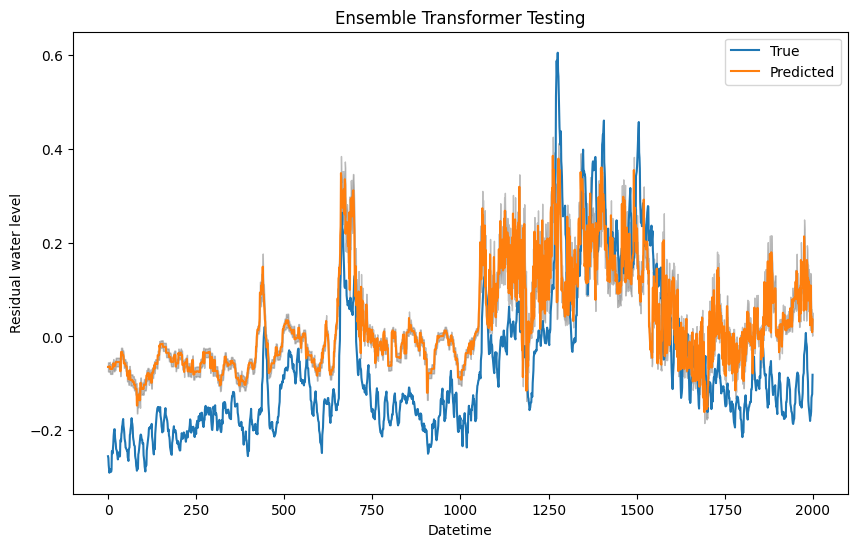

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_val, y_mean)
mae = mean_absolute_error(y_val, y_mean)
print(f"Validation MSE: {mse}")
print(f"Validation MAE: {mae}")

upper_bound = y_mean + std_dev_val
lower_bound = y_mean - std_dev_val
upper_bound = upper_bound.reshape(upper_bound.shape[0])
lower_bound = lower_bound.reshape(lower_bound.shape[0])

plt.figure(figsize=(10, 6))
plt.plot(y_val, label='True')
plt.plot(y_mean, label='Predicted')
plt.fill_between(range(len(y_val)), upper_bound, lower_bound, color='gray', alpha=0.5)
plt.legend()
plt.xlabel('Datetime')
plt.ylabel('Residual water level')
plt.title("Ensemble Transformer Testing")
plt.show()

Validation MSE: 0.005339237934024033
Validation MAE: 0.05141081666236297


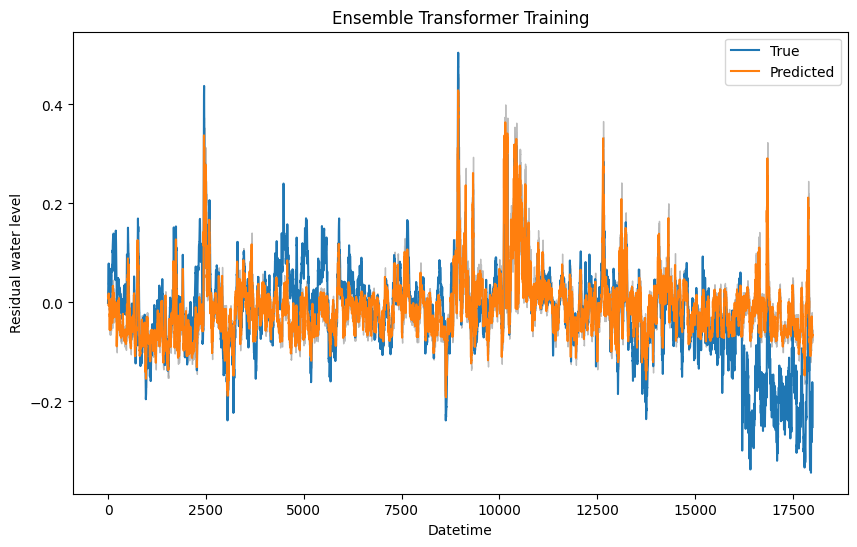

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_train, train_mean)
mae = mean_absolute_error(y_train, train_mean)
print(f"Validation MSE: {mse}")
print(f"Validation MAE: {mae}")

upper_bound = train_mean + std_dev_train
lower_bound = train_mean - std_dev_train
upper_bound = upper_bound.reshape(upper_bound.shape[0])
lower_bound = lower_bound.reshape(lower_bound.shape[0])

plt.figure(figsize=(10, 6))
plt.plot(y_train, label='True')
plt.plot(train_mean, label='Predicted')
plt.fill_between(range(len(y_train)), upper_bound, lower_bound, color='gray', alpha=0.5)
plt.legend()
plt.xlabel('Datetime')
plt.ylabel('Residual water level')
plt.title("Ensemble Transformer Training")
plt.show()

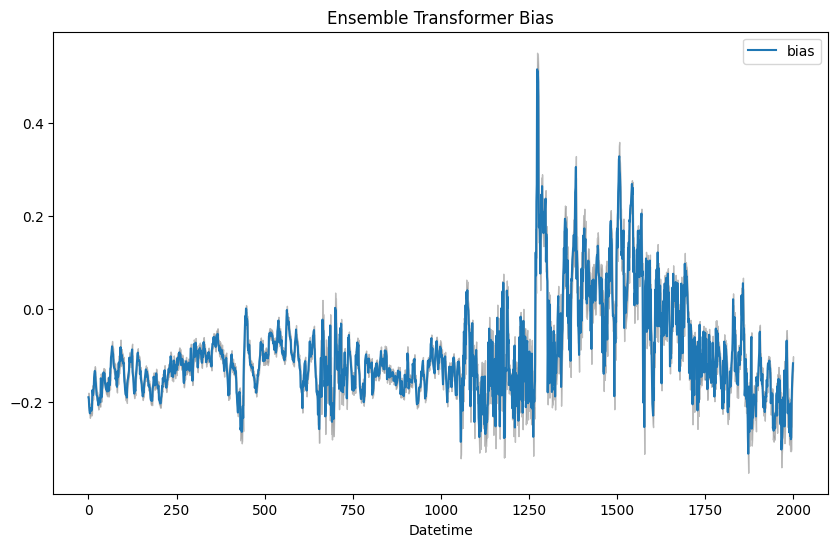

In [ ]:
y_mean = y_mean.reshape(y_mean.shape[0])
std_dev_val = std_dev_val.reshape(std_dev_val.shape[0])

upper_bound = y_val - y_mean + std_dev_val
lower_bound = y_val - y_mean - std_dev_val
upper_bound = upper_bound.reshape(upper_bound.shape[0])
lower_bound = lower_bound.reshape(lower_bound.shape[0])

#for combined bias plot
transformer_upper_bound = upper_bound
transformer_lower_bound = lower_bound

plt.figure(figsize=(10, 6))
plt.plot(y_val - y_mean, label='bias')
plt.fill_between(range(len(y_val)), upper_bound, lower_bound, color='gray', alpha=0.5)
plt.title('Ensemble Transformer Bias')
plt.xlabel('Datetime')
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

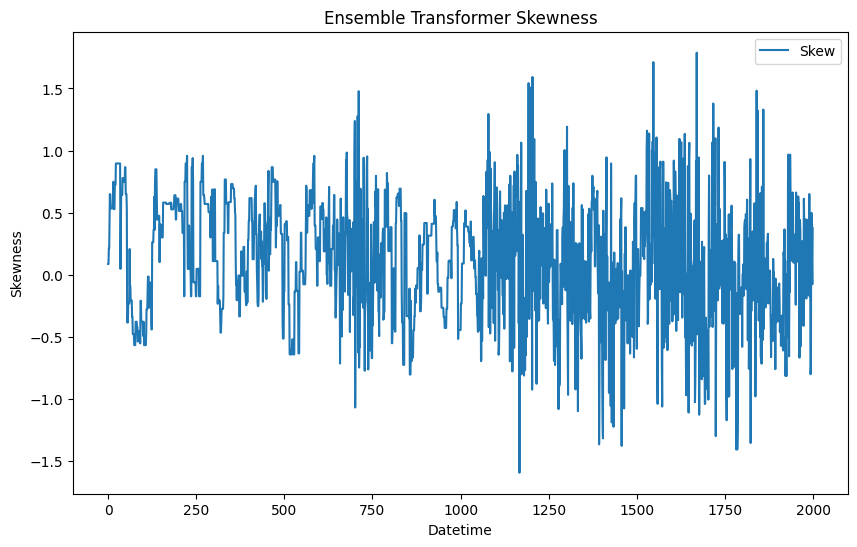

In [ ]:
from scipy.stats import skew

plt.figure(figsize=(10, 6))
skewness = skew(y_pred_list, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(skewness, label='Skew')
plt.xlabel('Datetime')
plt.ylabel('Skewness')
plt.title('Ensemble Transformer Skewness')
plt.legend()
plt.show()
#

#MLP ensemble

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import os
from pylab import date2num as d2n
import pickle
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

from datetime import  timedelta, datetime
import matplotlib.dates as mdates

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

In [ ]:
def cal_metric(y_true, y_pred, desc):

    mae = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse= np.sqrt(metrics.mean_squared_error(y_true, y_pred)) # or mse**(0.5)
    maxerr = metrics.max_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    abs_err = np.abs(y_true.values-y_pred.values)
    ae99 = np.percentile(abs_err, 99)
    ae95 = np.percentile(abs_err, 95)

    print(desc)
    print("MAE:",'{:.4f}'.format(mae))
    print("MSE:", '{:.4f}'.format(mse))
    print("RMSE:", '{:.4f}'.format(rmse))
    print("R2:", '{:.4f}'.format(r2))
    print("MaxErr:", '{:.4f}'.format(maxerr))
    print("99p_AbsErr:", '{:.4f}'.format(ae99))
    print("95p:", '{:.4f}'.format(ae95))
    return (mae, r2, ae95)

def plot_model_forecast(X_train, X_test, X_forecast, Observed, model, title):

    y_train_predictions = model.predict(X_train)
    y_test_predictions = model.predict(X_test)
    y_forecast_predictions = model.predict(X_forecast)
    train_predictions_df =pd.DataFrame(data = y_train_predictions, index =y_train.index )
    test_predictions_df =pd.DataFrame(data = y_test_predictions, index =y_test.index )
    forecast_predictions_df =pd.DataFrame(data = y_forecast_predictions, index =X_forecast.index )


    plt.figure()
    plt.plot(Observed,'k',label = 'Observed WL residual')
    plt.plot(train_predictions_df,'.b',alpha = 0.5, label = 'Train WL residual')
    plt.plot(test_predictions_df,'.r',alpha = 0.5,label = 'Test WL residual')
    plt.plot(forecast_predictions_df,'.g',alpha = 0.5,label = 'Forecast WL residual')
    plt.ylabel('m')
    plt.title(title)
    plt.legend()

def plot_model2(X, Observed,model ,title):

    predictions = model.predict(X)
    predictions_df =pd.DataFrame(data = predictions, index =Observed.index )

    plt.figure()
    plt.plot(Observed,'k',label = 'Observed residual')
    plt.plot(predictions_df,'.b',alpha = 0.5, label = 'Predicted residual')
    plt.ylabel('m')
    plt.title(title)
    plt.legend()

def lagcorrWL(observation, model_prediction,pred_tide, error_vec, lag):
    lagged=error_vec.shift(lag)
    prediction = model_prediction+lagged+pred_tide
    nb_na = lagged.isna().sum()# count the row that are NaN due to the shift
    thr = -0.1 # exclude the WL that is at low tide because of flat bottom WL
    maskwl = observation>thr #True where WL >thr

    y_true=observation[nb_na:].loc[maskwl]
    y_pred=prediction[nb_na:].loc[maskwl]
    #r2 = metrics.r2_score(y_true, y_pred)
    #mae = metrics.mean_absolute_error(y_true, y_pred)
    abs_err = np.abs(y_true.values-y_pred.values)
    ae95 = np.percentile(abs_err, 95)
    return ae95

def sse_loss(y_true, y_pred):
    return tf.reduce_sum(tf.square(y_true - y_pred))

def r2_loss(y_true, y_pred):
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - (1 - SS_res/(SS_tot + tf.keras.backend.epsilon()))

In [ ]:
dfX = pd.read_csv('/content/drive/MyDrive/hwy37/Input_trainingset.csv',parse_dates=[0], index_col=0)
dfY = pd.read_csv('/content/drive/MyDrive/hwy37/petaluma_wl_1hr.csv',parse_dates=[0], index_col=0)

X_df = pd.DataFrame(index = dfX.index)
# run a rolling mean with 12 window to get rid of the "fuzz"
X_df['Baro_pressure']=dfX.AtmPres.rolling(12, min_periods=1, center=True).mean()
X_df['Ocean_wind']=dfX.ocean_onshorewind.rolling(12, min_periods=1, center=True).mean()
X_df['Local_wind']=dfX.Gnoss_onshorewind.rolling(12, min_periods=1, center=True).mean()
# There is a delay between when a flow peak is observed at the flow gage and when its effect on the
# downstream water level gauge.
# The delay between Napa River flow and Novato Mouth is -3 hour
# The delay between Napa River flow and Rowland Bridge is -1 hour
# The delay between Napa River flow and Petaluma is -3 hour

lag = 0 # for now lets keep it at 0 because it create this gap between training and forecast
X_df['napa_flow_cfs'] = dfX.napa_flow_cfs.shift(lag)

# 2. Assure y and X_df are the same size and do not have NAN
# I concat them and delete any row that have NaN at the end. That assure
# we have a solid block of data with out the frayed ends or NaN at the beginning
X_df = pd.concat([X_df, dfY.residual_m], axis=1).dropna(how='any')

#corr_mat = X_df.corr()

y = X_df.residual_m
Y_df = dfY.truncate(before = X_df.index[0], after=X_df.index[-1], axis=0) # truncated version of the original WL DF

X_df = X_df.drop(columns=['residual_m'])
# X_df.info()

path_pstage = '/content/drive/MyDrive/hwy37/petaluma_wl_new.csv'
pet_stage = pd.read_csv(path_pstage)
p_stage = np.asarray(pet_stage)

path_p1hr = '/content/drive/MyDrive/hwy37/petaluma_wl_1hr.csv'
pet_stage_1hr = pd.read_csv(path_p1hr)
p_1hr = np.asarray(pet_stage_1hr)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_df[0:20000], y[0:20000], shuffle=False, test_size = 0.1)

aggregate_final_res = pd.DataFrame(index=X_val.index)
aggregate_train_res = pd.DataFrame(index=X_train.index)
mse_list = []
train_mse_list = []
degree = 3
shap_list = []

for i in range(10):
    scaler = MinMaxScaler()
    model = Sequential()
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam') #sse_loss

    pipe=make_pipeline(PolynomialFeatures(degree), scaler, model)
    pipe.fit(X_train, y_train)

    hindcast_df =pd.DataFrame(index =X_train.index)
    hindcast_df['hind_res'] = pipe.predict(X_train)
    error = y_train - hindcast_df.hind_res

    win = 12 # number of points to average
    hindcast_df['err_12hr_average']= error.rolling(win, center=False).mean()

    hindcast_df['hind_res_corrected']= hindcast_df.hind_res + hindcast_df.err_12hr_average

    nb_na = hindcast_df.err_12hr_average.isna().sum()

    hindcast_df['hind_final_WL'] = Y_df.predicted + hindcast_df.hind_res_corrected + 1.2025515990257196 #mean
    hindcast_df['obs_final_WL'] = Y_df.stage_m + 1.2025515990257196 #mean
    hindcast_df['pred_tide'] = Y_df.predicted + 1.2025515990257196 #mean

    forecast = pipe.predict(X_val)
    forecast_df =pd.DataFrame(data = forecast, index =X_val.index, columns=['pred_res'] )

    correction = hindcast_df.err_12hr_average[-1] # the last
    forecast_df['pred_res_corrected'] = forecast_df.pred_res + correction

    pet_stage_1hr['datetime'] = pd.to_datetime(pet_stage_1hr['Unnamed: 0'])
    pet_stage_1hr.set_index('datetime', inplace=True)

    forecast_df['pred_tide'] = pet_stage_1hr['predicted']
    forecast_df['pred_final_WL'] = forecast_df.pred_res_corrected  + forecast_df.pred_tide

    aggregate_final_res['pred_res_'+str(i)] = forecast_df['pred_res_corrected']
    aggregate_train_res['pred_res_'+str(i)] = hindcast_df['hind_res_corrected']

    mse = mean_squared_error(y_val, forecast_df['pred_res_corrected'])
    mse_list.append(mse)
    print(f"Mean Squared Error: {mse}")

    #train_mse = mean_squared_error(y_train, hindcast_df['hind_res_corrected'])
    #train_mse_list.append(train_mse)
    #print(f"Mean Squared Error: {train_mse}")

    # Fits the explainer
    #explainer = shap.Explainer(pipe.predict , X_train)
    # Calculates the SHAP values - It takes some time
    #shap_values = explainer(X_val)
    #shap_list.append(shap_values)

    #plt.figure(figsize=(10, 6))
    #plt.plot(y_val, label='Actual')
    #plt.plot(forecast_df['pred_res_corrected'], label='Predicted')
    #plt.xlabel('Date')
    #plt.ylabel('Residual water level')
    #plt.title('MLP with hindcast')
    #plt.legend()
    #plt.show()

563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0078
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
<ipython-input-41-e171e78f438c>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  correction = hindcast_df.err_12hr_average[-1] # the last


Mean Squared Error: 0.004675427751541253
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0083
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
<ipython-input-41-e171e78f438c>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  correction = hindcast_df.err_12hr_average[-1] # the last


Mean Squared Error: 0.007148527677744468
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0070
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
<ipython-input-41-e171e78f438c>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  correction = hindcast_df.err_12hr_average[-1] # the last


Mean Squared Error: 0.0057432909279047095
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0077
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
<ipython-input-41-e171e78f438c>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  correction = hindcast_df.err_12hr_average[-1] # the last


Mean Squared Error: 0.0067633905323583625
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0098
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
<ipython-input-41-e171e78f438c>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  correction = hindcast_df.err_12hr_average[-1] # the last


Mean Squared Error: 0.012766581152525906
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0084
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Mean Squared Error: 0.006263709955652431


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
<ipython-input-41-e171e78f438c>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  correction = hindcast_df.err_12hr_average[-1] # the last


563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0070
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
<ipython-input-41-e171e78f438c>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  correction = hindcast_df.err_12hr_average[-1] # the last


Mean Squared Error: 0.013532904967578897
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0070
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
<ipython-input-41-e171e78f438c>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  correction = hindcast_df.err_12hr_average[-1] # the last


Mean Squared Error: 0.006926038090595966
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0074
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
<ipython-input-41-e171e78f438c>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  correction = hindcast_df.err_12hr_average[-1] # the last


Mean Squared Error: 0.016931204007722984
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0077
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
<ipython-input-41-e171e78f438c>:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  correction = hindcast_df.err_12hr_average[-1] # the last


Mean Squared Error: 0.005643336693050063


Overall Mean Squared Error: 0.008639441175667503


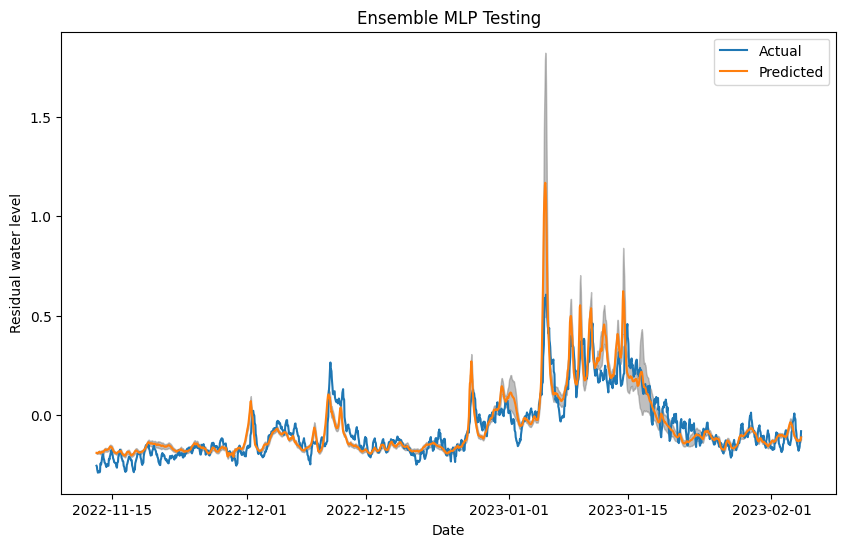

In [ ]:
overall_mse = np.mean(mse_list)
print(f"Overall Mean Squared Error: {overall_mse}")

aggregate_final_res['pred_res_mean'] = aggregate_final_res.iloc[:, :10].mean(axis=1)
aggregate_final_res['std_dev'] = aggregate_final_res.iloc[:, :10].std(axis=1)
upper_bound = aggregate_final_res['pred_res_mean'] + aggregate_final_res['std_dev']
lower_bound = aggregate_final_res['pred_res_mean'] - aggregate_final_res['std_dev']

plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual')
plt.plot(aggregate_final_res['pred_res_mean'], label='Predicted')
plt.fill_between(y_val.index, upper_bound, lower_bound, color='gray', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Residual water level')
plt.legend()
plt.title('Ensemble MLP Testing')
plt.show()

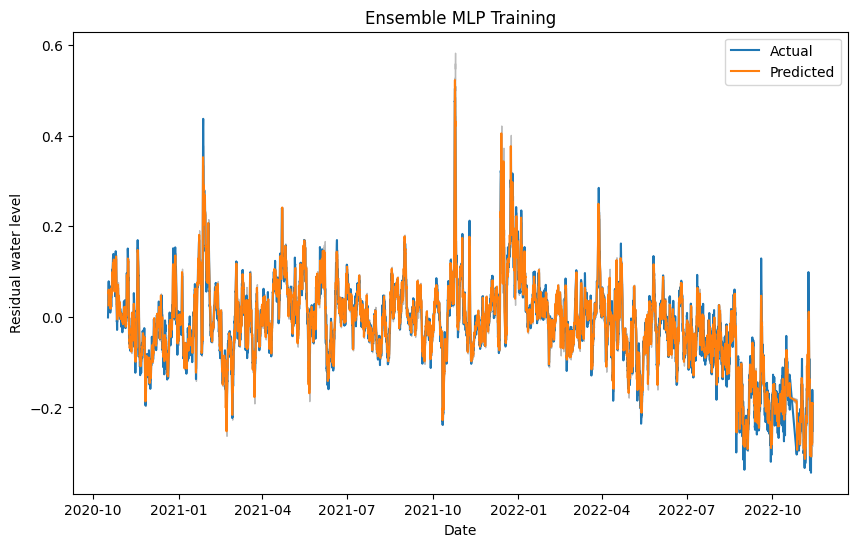

In [ ]:
aggregate_train_res['pred_res_mean'] = aggregate_train_res.iloc[:, :10].mean(axis=1)
aggregate_train_res['std_dev'] = aggregate_train_res.iloc[:, :10].std(axis=1)
upper_bound = aggregate_train_res['pred_res_mean'] + aggregate_train_res['std_dev']
lower_bound = aggregate_train_res['pred_res_mean'] - aggregate_train_res['std_dev']

plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual')
plt.plot(aggregate_train_res['pred_res_mean'], label='Predicted')
plt.fill_between(y_train.index, upper_bound, lower_bound, color='gray', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Residual water level')
plt.legend()
plt.title('Ensemble MLP Training')
plt.show()

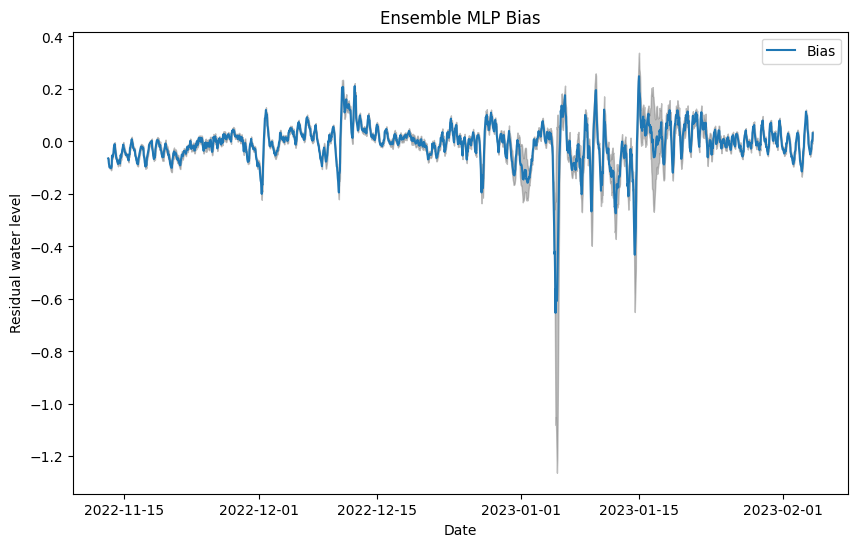

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_val - aggregate_final_res['pred_res_mean'], label='Bias')
upper_bound = y_val - aggregate_final_res['pred_res_mean'] + aggregate_final_res['std_dev']
lower_bound = y_val - aggregate_final_res['pred_res_mean'] - aggregate_final_res['std_dev']
#for combined bias
mlp_upper_bound = upper_bound
mlp_lower_bound = lower_bound

plt.fill_between(y_val.index, upper_bound, lower_bound, color='gray', alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Residual water level')
plt.title('Ensemble MLP Bias')
plt.legend()

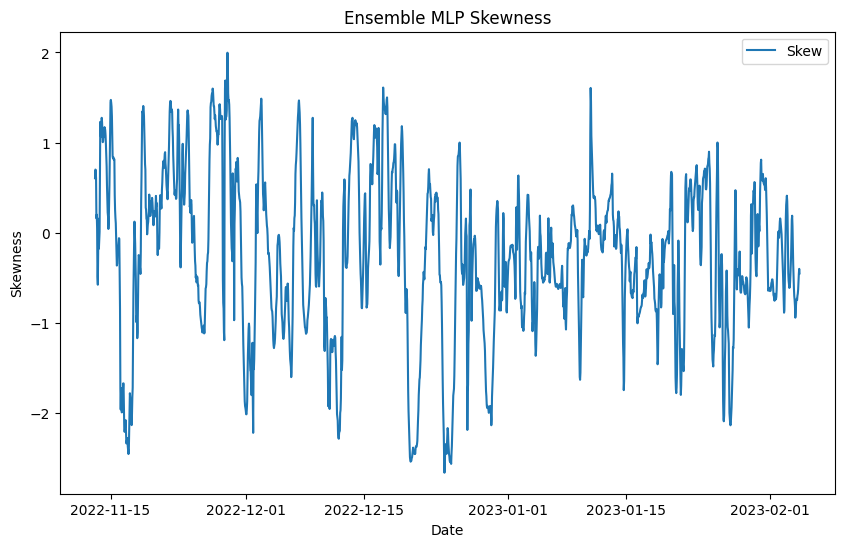

In [ ]:
aggregate_final_res['pred_res_skew'] = aggregate_final_res.iloc[:, :10].skew(axis = 1)

plt.figure(figsize=(10, 6))
plt.plot(aggregate_final_res['pred_res_skew'], label='Skew')
plt.xlabel('Date')
plt.ylabel('Skewness')
plt.title('Ensemble MLP Skewness')
plt.legend()

#LSTM Ensemble

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import os
from pylab import date2num as d2n
import pickle
import shap

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

from datetime import  timedelta, datetime
import matplotlib.dates as mdates

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
#LSTM training step
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

dfX = pd.read_csv('/content/drive/MyDrive/hwy37/Input_trainingset.csv',parse_dates=[0], index_col=0)
dfY = pd.read_csv('/content/drive/MyDrive/hwy37/petaluma_wl_1hr.csv',parse_dates=[0], index_col=0)

X_df = pd.DataFrame(index = dfX.index)
# run a rolling mean with 12 window to get rid of the "fuzz"
X_df['Baro_pressure']=dfX.AtmPres.rolling(12, min_periods=1, center=True).mean()
X_df['Ocean_wind']=dfX.ocean_onshorewind.rolling(12, min_periods=1, center=True).mean()
X_df['Local_wind']=dfX.Gnoss_onshorewind.rolling(12, min_periods=1, center=True).mean()
# There is a delay between when a flow peak is observed at the flow gage and when its effect on the
# downstream water level gauge.
# The delay between Napa River flow and Novato Mouth is -3 hour
# The delay between Napa River flow and Rowland Bridge is -1 hour
# The delay between Napa River flow and Petaluma is -3 hour

lag = 0 # for now lets keep it at 0 because it create this gap between training and forecast
X_df['napa_flow_cfs'] = dfX.napa_flow_cfs.shift(lag)

# 2. Assure y and X_df are the same size and do not have NAN
# I concat them and delete any row that have NaN at the end. That assure
# we have a solid block of data with out the frayed ends or NaN at the beginning
X_df = pd.concat([X_df, dfY.residual_m], axis=1).dropna(how='any')

#corr_mat = X_df.corr()

y = X_df.residual_m
later_y = X_df.residual_m
Y_df = dfY.truncate(before = X_df.index[0], after=X_df.index[-1], axis=0) # truncated version of the original WL DF

X_df = X_df.drop(columns=['residual_m'])
# X_df.info()

X = X_df[0:20000]
y = y[0:20000]

#poly = PolynomialFeatures(degree=2)
#X = poly.fit_transform(X)
#X = pd.DataFrame(X)

# Define the number of previous time steps to consider
look_back = 24
n_features = X.shape[1]

# Create a dataset with lagged features
def create_dataset(X, y, look_back):
    dataX, dataY = [], []
    for i in range(len(X) - look_back - 1):
        a = X[i:(i + look_back)]
        dataX.append(a)
        dataY.append(y[i + look_back])
    return np.array(dataX), np.array(dataY)

def sse_loss(y_true, y_pred):
    return tf.reduce_sum(tf.square(y_true - y_pred))

def r2_loss(y_true, y_pred):
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - (1 - SS_res/(SS_tot + tf.keras.backend.epsilon()))

X, y = create_dataset(X.values, y.values, look_back)

X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=False, test_size = 0.1)

X_train = np.asarray(X_train)
X_val = np.asarray(X_val)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train = scaler_x.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler_x.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(17977, 24, 4)
(1998, 24, 4)
(17977,)
(1998,)


In [ ]:
lstm_aggregate_final_res = pd.DataFrame(index=X_df.index[(20000 - X_val.shape[0]):20000]) #17990
lstm_aggregate_train_res = pd.DataFrame(index=X_df.index[(18000 - X_train.shape[0]):18000])
lstm_mse_list = []
shap_list = []

for i in range(10):
    model = Sequential()
    #model.add(InputLayer(shape=(None, X_train.shape[1])))
    model.add(InputLayer(shape=(look_back, n_features))) #n_features or X_train.shape[1]
    model.add(LSTM(10, activation='relu', recurrent_activation='sigmoid'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')

    #pipe=make_pipeline(model)
    model.fit(X_train, y_train, epochs=20, verbose=1)

    dfX_train, dfX_test, dfY_train, dfY_test = train_test_split(X_df[0:20000], later_y[0:20000], shuffle=False, test_size = 0.1)
    hindcast_df =pd.DataFrame(index =dfX_train.index[(18000 - X_train.shape[0]):18000])
    hindcast_df['hind_res'] = model.predict(X_train)

    error = dfY_train - hindcast_df.hind_res

    win = 12 # number of points to average
    hindcast_df['err_12hr_average']= error.rolling(win, center=False).mean()

    hindcast_df['hind_res_corrected']= hindcast_df.hind_res + hindcast_df.err_12hr_average

    nb_na = hindcast_df.err_12hr_average.isna().sum()

    hindcast_df['hind_final_WL'] = Y_df[0:22040].predicted + hindcast_df.hind_res_corrected + 1.2025515990257196 #mean
    hindcast_df['obs_final_WL'] = Y_df[0:22040].stage_m + 1.2025515990257196 #mean
    hindcast_df['pred_tide'] = Y_df[0:22040].predicted + 1.2025515990257196 #mean

    forecast = model.predict(X_val)
    forecast_df =pd.DataFrame(data = forecast, index =dfX_test.index[(2000 - X_val.shape[0]):2000], columns=['pred_res'] )

    correction = hindcast_df.err_12hr_average[-1] # the last
    forecast_df['pred_res_corrected'] = forecast_df.pred_res + correction

    lstm_aggregate_final_res['pred_res_'+str(i)] = forecast_df['pred_res_corrected']
    lstm_aggregate_train_res['pred_res_'+str(i)] = hindcast_df['hind_res_corrected']

    mse = mean_squared_error(y_val, forecast)
    lstm_mse_list.append(mse)
    print(f"Mean Squared Error: {mse}")

    # Calculates the SHAP values - It takes some time
    #flat_train = X_train.reshape(X_train.shape[0], -1)
    #flat_val = X_val.reshape(X_val.shape[0], -1)
    def predict_flattened(X):
        X_reshaped = X.reshape(X.shape[0], look_back, n_features)
        return model.predict(X_reshaped)

    #explainer = shap.KernelExplainer(predict_flattened, flat_train[:100])
    #shap_values = explainer.shap_values(flat_val[0:100])
    #shap_list.append(shap_values)

    #mse = mean_squared_error(dfY_test[0:1999], forecast_df['pred_res'])
    #print(f"Mean Squared Error: {mse}")

    #plt.figure(figsize=(10, 6))
    #plt.plot(dfY_test[(2000 - X_val.shape[0]):2000], label='Actual')
    #plt.plot(forecast_df['pred_res_corrected'], label='Predicted')
    #plt.xlabel('Index')
    #plt.ylabel('Values')
    #plt.title('LSTM')
    #plt.legend()
    #plt.show()

Epoch 1/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0135
Epoch 2/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0090
Epoch 3/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0088
Epoch 4/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0089
Epoch 5/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0088
Epoch 6/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0088
Epoch 7/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0085
Epoch 8/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0086
Epoch 9/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0085
Epoch 10/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0084
Epoch 11/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0082
Epoch 12/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0082
Epoch 13/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0082
Epoch 14/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0082
Epoch 15/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

<ipython-input-46-c8d443c86635>:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  correction = hindcast_df.err_12hr_average[-1] # the last


562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0139
Epoch 2/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0092
Epoch 3/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0089
Epoch 4/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0088
Epoch 5/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0087
Epoch 6/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0086
Epoch 7/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0086
Epoch 8/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0085
Epoch 9/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0083
Epoch 10/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0084
Epoch 11/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0083
Epoch 12/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0084
Epoch 13/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0082
Epoch 14/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0082
Epoch 15/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0081


<ipython-input-46-c8d443c86635>:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  correction = hindcast_df.err_12hr_average[-1] # the last


562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0119
Epoch 2/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0088
Epoch 3/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0086
Epoch 4/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0083
Epoch 5/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0085
Epoch 6/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0083
Epoch 7/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0084
Epoch 8/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0080
Epoch 9/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0080
Epoch 10/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0081
Epoch 11/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0077
Epoch 12/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0075
Epoch 13/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0078
Epoch 14/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0078
Epoch 15/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0076


<ipython-input-46-c8d443c86635>:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  correction = hindcast_df.err_12hr_average[-1] # the last


562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0114
Epoch 2/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0090
Epoch 3/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0088
Epoch 4/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0086
Epoch 5/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0086
Epoch 6/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0085
Epoch 7/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0084
Epoch 8/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0085
Epoch 9/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0083
Epoch 10/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0083
Epoch 11/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0081
Epoch 12/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0081
Epoch 13/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0081
Epoch 14/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0081
Epoch 15/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0080


<ipython-input-46-c8d443c86635>:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  correction = hindcast_df.err_12hr_average[-1] # the last


562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0129
Epoch 2/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0088
Epoch 3/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0086
Epoch 4/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0087
Epoch 5/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0085
Epoch 6/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0084
Epoch 7/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0087
Epoch 8/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0084
Epoch 9/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0084
Epoch 10/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0083
Epoch 11/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0083
Epoch 12/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0082
Epoch 13/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0080
Epoch 14/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0083
Epoch 15/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0081


<ipython-input-46-c8d443c86635>:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  correction = hindcast_df.err_12hr_average[-1] # the last


562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0119
Epoch 2/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0086
Epoch 3/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0085
Epoch 4/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0084
Epoch 5/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0086
Epoch 6/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0081
Epoch 7/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0082
Epoch 8/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0082
Epoch 9/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0080
Epoch 10/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0081
Epoch 11/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0081
Epoch 12/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0079
Epoch 13/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0081
Epoch 14/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0079
Epoch 15/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0079


<ipython-input-46-c8d443c86635>:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  correction = hindcast_df.err_12hr_average[-1] # the last


562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0149
Epoch 2/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0088
Epoch 3/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0086
Epoch 4/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0085
Epoch 5/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0087
Epoch 6/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0084
Epoch 7/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0082
Epoch 8/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0083
Epoch 9/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0079
Epoch 10/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0079
Epoch 11/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0079
Epoch 12/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0078
Epoch 13/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0079
Epoch 14/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0076
Epoch 15/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0076


<ipython-input-46-c8d443c86635>:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  correction = hindcast_df.err_12hr_average[-1] # the last


562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0122
Epoch 2/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0087
Epoch 3/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0088
Epoch 4/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0088
Epoch 5/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0086
Epoch 6/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0085
Epoch 7/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0084
Epoch 8/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0083
Epoch 9/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0084
Epoch 10/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0083
Epoch 11/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0082
Epoch 12/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0081
Epoch 13/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0080
Epoch 14/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0081
Epoch 15/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0079


<ipython-input-46-c8d443c86635>:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  correction = hindcast_df.err_12hr_average[-1] # the last


562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0116
Epoch 2/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0091
Epoch 3/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0091
Epoch 4/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0089
Epoch 5/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0088
Epoch 6/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0087
Epoch 7/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0085
Epoch 8/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0085
Epoch 9/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0087
Epoch 10/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0089
Epoch 11/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0088
Epoch 12/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0087
Epoch 13/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0085
Epoch 14/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0084
Epoch 15/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0082


<ipython-input-46-c8d443c86635>:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  correction = hindcast_df.err_12hr_average[-1] # the last


562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0124
Epoch 2/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0090
Epoch 3/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0086
Epoch 4/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0085
Epoch 5/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0085
Epoch 6/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0085
Epoch 7/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0084
Epoch 8/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0082
Epoch 9/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0083
Epoch 10/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0082
Epoch 11/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0081
Epoch 12/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0079
Epoch 13/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0081
Epoch 14/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0079
Epoch 15/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0078


<ipython-input-46-c8d443c86635>:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  correction = hindcast_df.err_12hr_average[-1] # the last


Overall Mean Squared Error: 0.028043990538697616


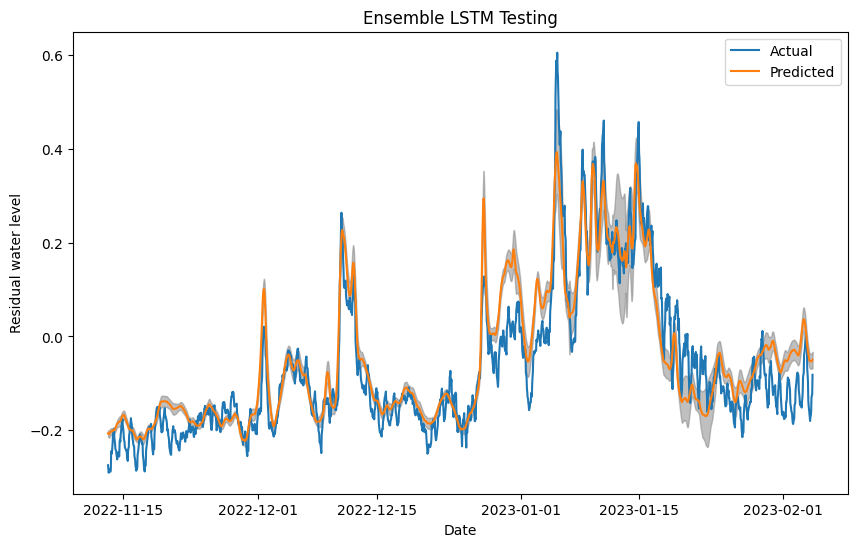

In [ ]:
overall_mse = np.mean(lstm_mse_list)
print(f"Overall Mean Squared Error: {overall_mse}")

lstm_aggregate_final_res['pred_res_mean'] = lstm_aggregate_final_res.iloc[:, :10].mean(axis=1) #aggregate_final_res.mean(axis=1)
lstm_aggregate_final_res['std_dev'] = lstm_aggregate_final_res.iloc[:, :10].std(axis=1) #aggregate_final_res.std(axis=1)
upper_bound = lstm_aggregate_final_res['pred_res_mean'] + lstm_aggregate_final_res['std_dev']
lower_bound = lstm_aggregate_final_res['pred_res_mean'] - lstm_aggregate_final_res['std_dev']

plt.figure(figsize=(10, 6))
plt.plot(dfY_test[(2000 - X_val.shape[0]):2000], label='Actual')
plt.plot(lstm_aggregate_final_res['pred_res_mean'], label='Predicted')
plt.fill_between(dfY_test.index[(2000 - X_val.shape[0]):2000], upper_bound, lower_bound, color='gray', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Residual water level')
plt.legend()
plt.title('Ensemble LSTM Testing')
plt.show()

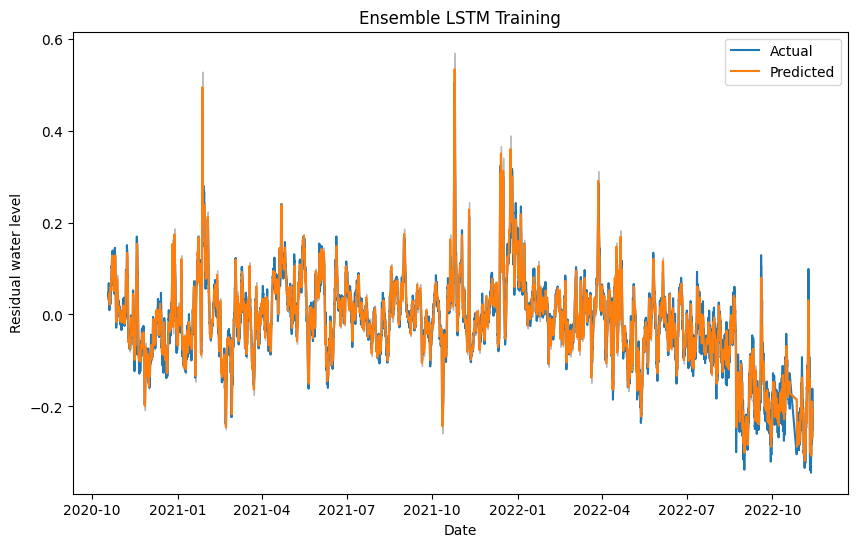

In [ ]:
lstm_aggregate_train_res['pred_res_mean'] = lstm_aggregate_train_res.iloc[:, :10].mean(axis=1) #aggregate_final_res.mean(axis=1)
lstm_aggregate_train_res['std_dev'] = lstm_aggregate_train_res.iloc[:, :10].std(axis=1) #aggregate_final_res.std(axis=1)
upper_bound = lstm_aggregate_train_res['pred_res_mean'] + lstm_aggregate_train_res['std_dev']
lower_bound = lstm_aggregate_train_res['pred_res_mean'] - lstm_aggregate_train_res['std_dev']

plt.figure(figsize=(10, 6))
plt.plot(dfY_train[(18000 - X_train.shape[0]):18000], label='Actual')
plt.plot(lstm_aggregate_train_res['pred_res_mean'], label='Predicted')
plt.fill_between(dfY_train.index[(18000 - X_train.shape[0]):18000], upper_bound, lower_bound, color='gray', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Residual water level')
plt.legend()
plt.title('Ensemble LSTM Training')
plt.show()

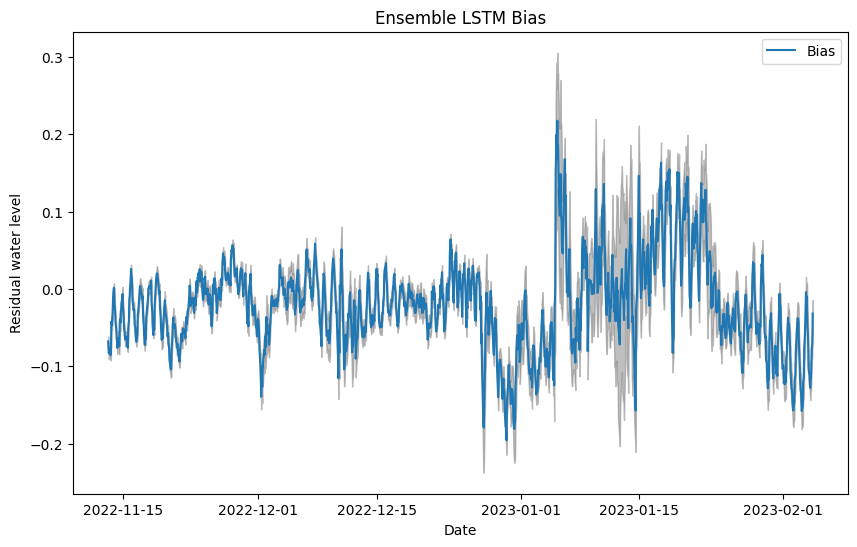

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(dfY_test - lstm_aggregate_final_res['pred_res_mean'], label='Bias')
upper_bound = dfY_test[(2000 - X_val.shape[0]):2000] - lstm_aggregate_final_res['pred_res_mean'] + lstm_aggregate_final_res['std_dev']
lower_bound = dfY_test[(2000 - X_val.shape[0]):2000] - lstm_aggregate_final_res['pred_res_mean'] - lstm_aggregate_final_res['std_dev']

#for combined bias
lstm_upper_bound = upper_bound
lstm_lower_bound = lower_bound

plt.fill_between(dfY_test.index[(2000 - X_val.shape[0]):2000], upper_bound, lower_bound, color='gray', alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Residual water level')
plt.title('Ensemble LSTM Bias')
plt.legend()

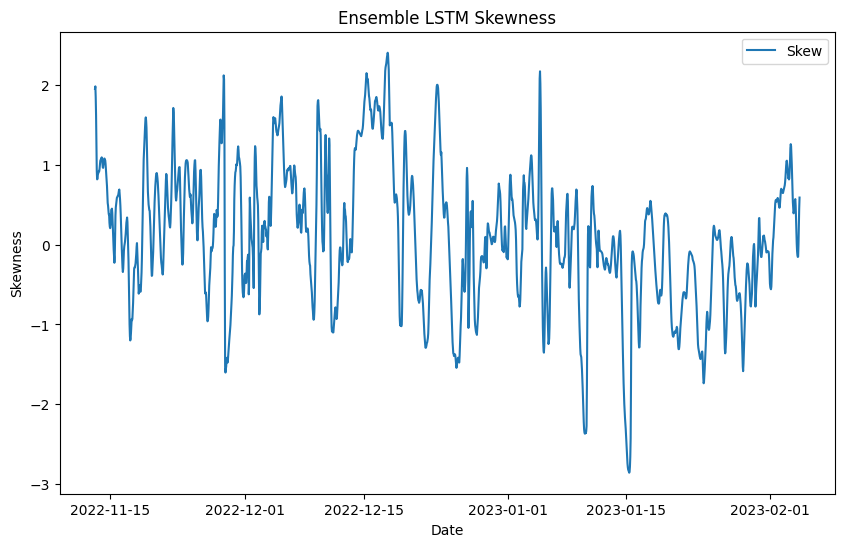

In [ ]:
lstm_aggregate_final_res['pred_res_skew'] = lstm_aggregate_final_res.iloc[:, :10].skew(axis = 1)

plt.figure(figsize=(10, 6))
plt.plot(lstm_aggregate_final_res['pred_res_skew'], label='Skew')
plt.xlabel('Date')
plt.ylabel('Skewness')
plt.title('Ensemble LSTM Skewness')
plt.legend()

#Linear Regression

In [ ]:
def cal_metric(y_true, y_pred, desc):

    mae = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse= np.sqrt(metrics.mean_squared_error(y_true, y_pred)) # or mse**(0.5)
    maxerr = metrics.max_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    abs_err = np.abs(y_true.values-y_pred.values)
    ae99 = np.percentile(abs_err, 99)
    ae95 = np.percentile(abs_err, 95)

    print(desc)
    print("MAE:",'{:.4f}'.format(mae))
    print("MSE:", '{:.4f}'.format(mse))
    print("RMSE:", '{:.4f}'.format(rmse))
    print("R2:", '{:.4f}'.format(r2))
    print("MaxErr:", '{:.4f}'.format(maxerr))
    print("99p_AbsErr:", '{:.4f}'.format(ae99))
    print("95p:", '{:.4f}'.format(ae95))
    return (mae, r2, ae95)

def plot_model_forecast(X_train, X_test, X_forecast, Observed, model, title):

    y_train_predictions = model.predict(X_train)
    y_test_predictions = model.predict(X_test)
    y_forecast_predictions = model.predict(X_forecast)
    train_predictions_df =pd.DataFrame(data = y_train_predictions, index =y_train.index )
    test_predictions_df =pd.DataFrame(data = y_test_predictions, index =y_test.index )
    forecast_predictions_df =pd.DataFrame(data = y_forecast_predictions, index =X_forecast.index )


    plt.figure()
    plt.plot(Observed,'k',label = 'Observed WL residual')
    plt.plot(train_predictions_df,'.b',alpha = 0.5, label = 'Train WL residual')
    plt.plot(test_predictions_df,'.r',alpha = 0.5,label = 'Test WL residual')
    plt.plot(forecast_predictions_df,'.g',alpha = 0.5,label = 'Forecast WL residual')
    plt.ylabel('m')
    plt.title(title)
    plt.legend()

def plot_model2(X, Observed,model ,title):

    predictions = model.predict(X)
    predictions_df =pd.DataFrame(data = predictions, index =Observed.index )

    plt.figure()
    plt.plot(Observed,'k',label = 'Observed residual')
    plt.plot(predictions_df,'.b',alpha = 0.5, label = 'Predicted residual')
    plt.ylabel('m')
    plt.title(title)
    plt.legend()

def lagcorrWL(observation, model_prediction,pred_tide, error_vec, lag):
    lagged=error_vec.shift(lag)
    prediction = model_prediction+lagged+pred_tide
    nb_na = lagged.isna().sum()# count the row that are NaN due to the shift
    thr = -0.1 # exclude the WL that is at low tide because of flat bottom WL
    maskwl = observation>thr #True where WL >thr

    y_true=observation[nb_na:].loc[maskwl]
    y_pred=prediction[nb_na:].loc[maskwl]
    #r2 = metrics.r2_score(y_true, y_pred)
    #mae = metrics.mean_absolute_error(y_true, y_pred)
    abs_err = np.abs(y_true.values-y_pred.values)
    ae95 = np.percentile(abs_err, 95)
    return ae95

In [ ]:
dfX = pd.read_csv('/content/drive/MyDrive/hwy37/Input_trainingset.csv',parse_dates=[0], index_col=0)
dfY = pd.read_csv('/content/drive/MyDrive/hwy37/petaluma_wl_1hr.csv',parse_dates=[0], index_col=0)

X_df = pd.DataFrame(index = dfX.index)
# run a rolling mean with 12 window to get rid of the "fuzz"
X_df['Baro_pressure']=dfX.AtmPres.rolling(12, min_periods=1, center=True).mean()
X_df['Ocean_wind']=dfX.ocean_onshorewind.rolling(12, min_periods=1, center=True).mean()
X_df['Local_wind']=dfX.Gnoss_onshorewind.rolling(12, min_periods=1, center=True).mean()
# There is a delay between when a flow peak is observed at the flow gage and when its effect on the
# downstream water level gauge.
# The delay between Napa River flow and Novato Mouth is -3 hour
# The delay between Napa River flow and Rowland Bridge is -1 hour
# The delay between Napa River flow and Petaluma is -3 hour

lag = 0 # for now lets keep it at 0 because it create this gap between training and forecast
X_df['napa_flow_cfs'] = dfX.napa_flow_cfs.shift(lag)

# 2. Assure y and X_df are the same size and do not have NAN
# I concat them and delete any row that have NaN at the end. That assure
# we have a solid block of data with out the frayed ends or NaN at the beginning
X_df = pd.concat([X_df, dfY.residual_m], axis=1).dropna(how='any')

#corr_mat = X_df.corr()

y = X_df.residual_m
Y_df = dfY.truncate(before = X_df.index[0], after=X_df.index[-1], axis=0) # truncated version of the original WL DF

X_df = X_df.drop(columns=['residual_m'])
# X_df.info()

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X_df, y, shuffle=True, test_size = 0.15,random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_df[0:20000], y[0:20000], shuffle=False, test_size = 0.1)
scaler = MinMaxScaler()
degree=3 # the 3rd degree polynomial is the one that gives the best results
pipe=make_pipeline(PolynomialFeatures(degree),scaler,LinearRegression())
pipe.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

In [ ]:
#hindcast_df =pd.DataFrame(index =X_df.index)
#hindcast_df['hind_res'] = pipe.predict(X_df)
hindcast_df =pd.DataFrame(index =X_train.index)
hindcast_df['hind_res'] = pipe.predict(X_train)

error = y_train - hindcast_df.hind_res
win = 12 # number of points to average
hindcast_df['err_12hr_average']= error.rolling(win, center=False).mean()

hindcast_df['hind_res_corrected']= hindcast_df.hind_res + hindcast_df.err_12hr_average

nb_na = hindcast_df.err_12hr_average.isna().sum()

hindcast_df['hind_final_WL'] = Y_df.predicted + hindcast_df.hind_res_corrected + 1.2025515990257196 #mean
hindcast_df['obs_final_WL'] = Y_df.stage_m + 1.2025515990257196 #mean
hindcast_df['pred_tide'] = Y_df.predicted + 1.2025515990257196 #mean

d1 = y # Observated Residual
d2 = hindcast_df.hind_res # Model prediction of residual
d3 = hindcast_df.err_12hr_average # average error last 12 hours
d4=Y_df.predicted # Predicted tide
d5=Y_df.stage_m
forecast = pipe.predict(X_val)
forecast_df =pd.DataFrame(data = forecast, index =X_val.index, columns=['pred_res'] )

correction = hindcast_df.err_12hr_average[-1] # the last
forecast_df['pred_res_corrected'] = forecast_df.pred_res + correction

pet_stage_1hr['datetime'] = pd.to_datetime(pet_stage_1hr['Unnamed: 0'])
pet_stage_1hr.set_index('datetime', inplace=True)

forecast_df['pred_tide'] = pet_stage_1hr['predicted']
forecast_df['pred_final_WL'] = forecast_df.pred_res_corrected  + forecast_df.pred_tide

<ipython-input-61-472068b7a207>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  correction = hindcast_df.err_12hr_average[-1] # the last


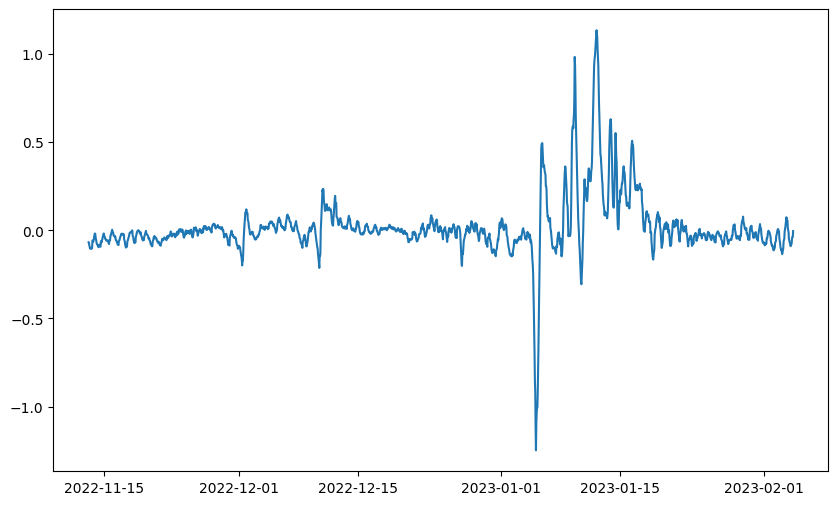

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_val - forecast_df['pred_res_corrected'], label='Bias')

#Combined Bias/Skew

In [ ]:
_train, X_val, y_train, y_val = train_test_split(X_df[0:20000], y[0:20000], shuffle=False, test_size = 0.1)

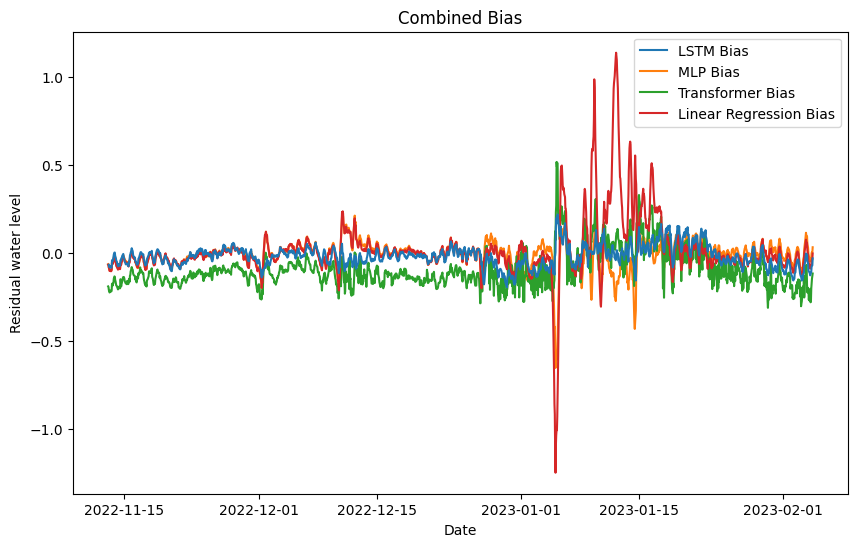

In [ ]:
plt.figure(figsize=(10, 6))
#LSTM
plt.plot(dfY_test - lstm_aggregate_final_res['pred_res_mean'], label='LSTM Bias', zorder=3) #df
#plt.fill_between(dfY_test.index[2:2000], lstm_upper_bound, lstm_lower_bound, color='gray', alpha=0.5)

#MLP
plt.plot(y_val - aggregate_final_res['pred_res_mean'], label='MLP Bias', zorder=1) #df
#plt.fill_between(y_val.index, mlp_upper_bound, mlp_lower_bound, color='gray', alpha=0.5)

#Transformer
plt.plot(y_val - y_mean, label='Transformer Bias', zorder=2) #array
#plt.fill_between(y_val.index, transformer_upper_bound, transformer_lower_bound, color='gray', alpha=0.5)

#Linear Regression
plt.plot(y_val - forecast_df['pred_res_corrected'], label='Linear Regression Bias')

plt.title('Combined Bias')
plt.xlabel('Date')
plt.ylabel('Residual water level')
plt.legend()
plt.show()

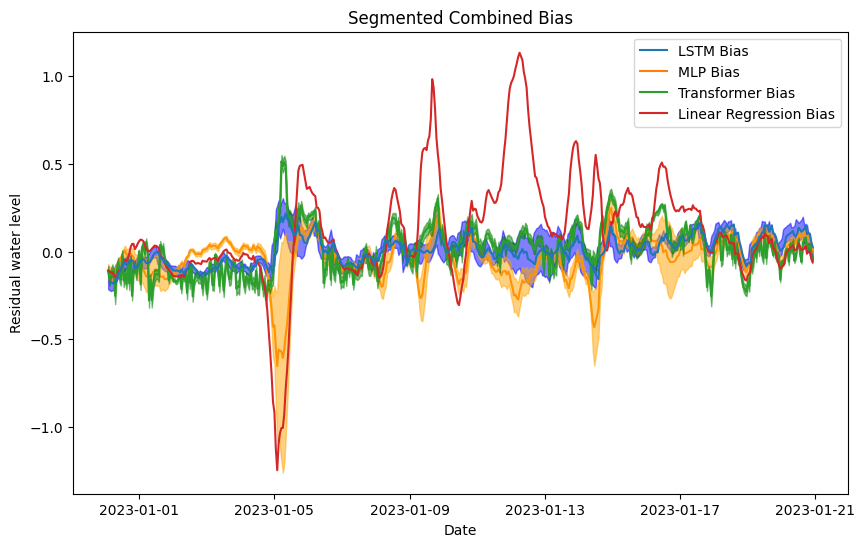

In [ ]:
plt.figure(figsize=(10, 6))
start = 1150
end = 1650

#LSTM
plt.plot(dfY_test[start:end] - lstm_aggregate_final_res['pred_res_mean'][start:end], label='LSTM Bias', zorder=3) #df
plt.fill_between(dfY_test.index[start:end], lstm_upper_bound[start:end], lstm_lower_bound[start:end], color='blue', alpha=0.5)

#MLP
plt.plot(y_val[start:end] - aggregate_final_res['pred_res_mean'][start:end], label='MLP Bias', zorder=1) #df
plt.fill_between(y_val.index[start:end], mlp_upper_bound[start:end], mlp_lower_bound[start:end], color='orange', alpha=0.5)

#Transformer
plt.plot(y_val[start:end] - y_mean[start:end], label='Transformer Bias', zorder=2) #array
plt.fill_between(y_val.index[start:end], transformer_upper_bound[start:end], transformer_lower_bound[start:end], color='green', alpha=0.5)

#Linear Regression
plt.plot(y_val[start:end] - forecast_df['pred_res_corrected'][start:end], label='Linear Regression Bias')

plt.title('Segmented Combined Bias')
plt.xlabel('Date')
plt.ylabel('Residual water level')
plt.legend()
plt.show()